In [90]:
import re
import numpy as np

def parse_and_process_iq(log_lines):
    # 存储结构：{counter: [ {...}, ... ]}
    data_per_counter = {}
    ranging_counter = None
    current_data = []
    for line in log_lines:
        # 检测counter标记
        m = re.search(r'I: Ranging data get completed for ranging counter (\d+)', line)
        if m:
            if ranging_counter is not None and current_data:
                # 按channel排序后保存
                current_data.sort(key=lambda x: x['channel'])
                data_per_counter[ranging_counter] = current_data
            ranging_counter = int(m.group(1))
            current_data = []
        # 解析IQ行
        m = re.match(r'id:(\d+), f:(\d+), ch:(\d+), ap:(\d+), li:(-?\d+), lq:(-?\d+), pi:(-?\d+), pq:(-?\d+)', line)
        if m:
            failed = int(m.group(2))
            if failed:
                continue
            channel = int(m.group(3))
            li, lq, pi, pq = map(int, [m.group(5), m.group(6), m.group(7), m.group(8)])
            # local/peer幅值和相位
            local_amp  = np.hypot(li, lq)
            local_phs  = np.arctan2(lq, li)
            peer_amp   = np.hypot(pi, pq)
            peer_phs   = np.arctan2(pq, pi)
            # signal = local x conj(peer)
            sig_i = li * pi - lq * pq
            sig_q = li * pq + lq * pi
            sig_amp = np.hypot(sig_i, sig_q)
            sig_phs = np.arctan2(sig_q, sig_i)
            entry = {
                'channel': channel,
                'local':  {'i': li, 'q': lq, 'amplitude': local_amp, 'phase': local_phs},
                'peer':   {'i': pi, 'q': pq, 'amplitude': peer_amp, 'phase': peer_phs},
                'signal': {'i': sig_i, 'q': sig_q, 'amplitude': sig_amp, 'phase': sig_phs},
            }
            current_data.append(entry)
    # 最后一组
    if ranging_counter is not None and current_data:
        current_data.sort(key=lambda x: x['channel'])
        data_per_counter[ranging_counter] = current_data
    return data_per_counter

# 用法举例
if __name__ == '__main__':
    # 1mcable.iq, angle.iq.test, close.AT.iq.txt, cable.angle.test
    # poster data in darkroom:dark.room.t2
    # poster data: meeting room:t4;loop walk:tloop ;
    # t88,clear
    with open('t86.txt', 'r', encoding='utf-8') as f:
        log_lines = f.readlines()
    data_per_counter = parse_and_process_iq(log_lines)

    # 访问数据示例
    for counter, ch_list in data_per_counter.items():
        print(f'Counter {counter}:')
        for entry in ch_list:
            ch = entry['channel']
            la, lp = entry['local']['amplitude'], entry['local']['phase']
            pa, pp = entry['peer']['amplitude'], entry['peer']['phase']
            sa, sp = entry['signal']['amplitude'], entry['signal']['phase']
            print(f' ch{ch}: local_amp={la:.1f} local_phase={lp:.3f}  '
                  f'peer_amp={pa:.1f} peer_phase={pp:.3f}  '
                  f'signal_amp={sa:.1f} signal_phase={sp:.3f}')

Counter 0:
 ch2: local_amp=147.8 local_phase=2.159  peer_amp=167.5 peer_phase=2.539  signal_amp=24766.7 signal_phase=-1.586
 ch5: local_amp=163.5 local_phase=0.833  peer_amp=185.4 peer_phase=-2.591  signal_amp=30317.8 signal_phase=-1.758
 ch8: local_amp=182.3 local_phase=-0.957  peer_amp=206.7 peer_phase=-1.077  signal_amp=37678.6 signal_phase=-2.034
 ch11: local_amp=185.9 local_phase=1.974  peer_amp=211.1 peer_phase=1.599  signal_amp=39247.1 signal_phase=-2.710
 ch14: local_amp=163.7 local_phase=0.612  peer_amp=185.8 peer_phase=2.630  signal_amp=30413.7 signal_phase=-3.042
 ch17: local_amp=158.0 local_phase=1.457  peer_amp=180.0 peer_phase=1.465  signal_amp=28446.0 signal_phase=2.922
 ch20: local_amp=139.7 local_phase=-2.729  peer_amp=160.0 peer_phase=-0.927  signal_amp=22354.2 signal_phase=2.627
 ch26: local_amp=117.0 local_phase=-3.116  peer_amp=131.0 peer_phase=-0.278  signal_amp=15337.0 signal_phase=2.889
 ch29: local_amp=107.4 local_phase=0.484  peer_amp=123.2 peer_phase=2.623  s

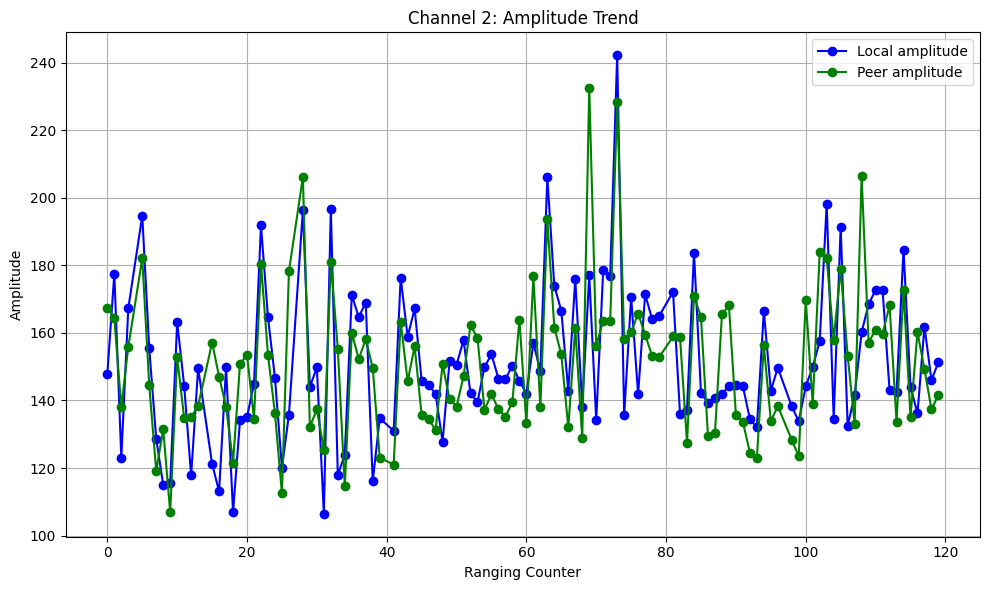

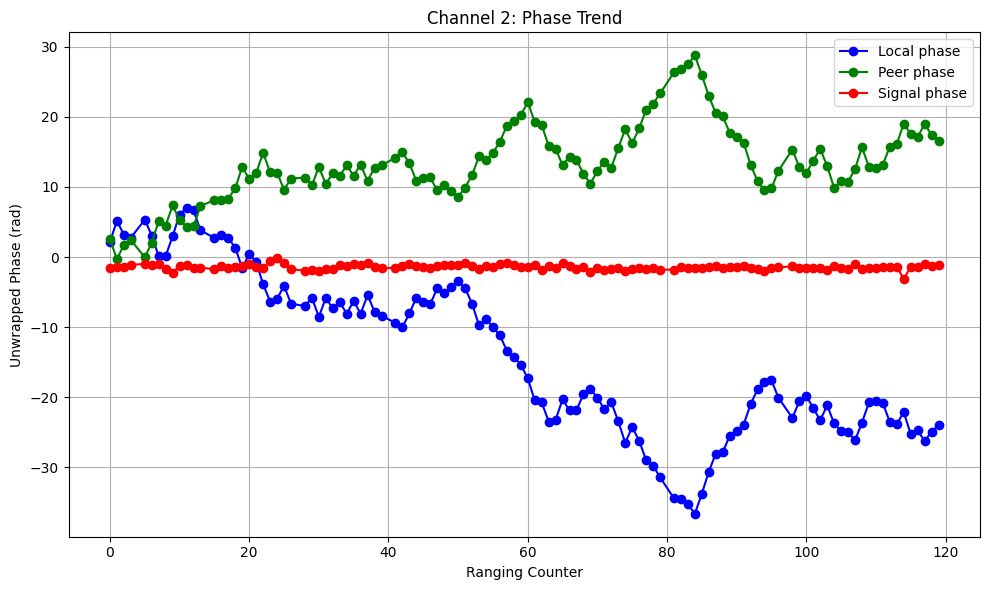

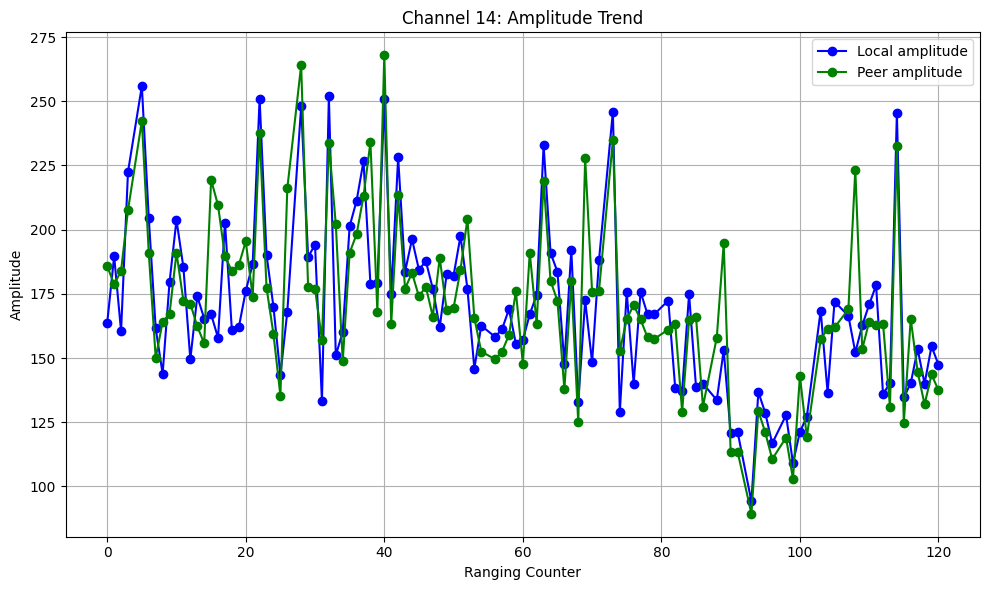

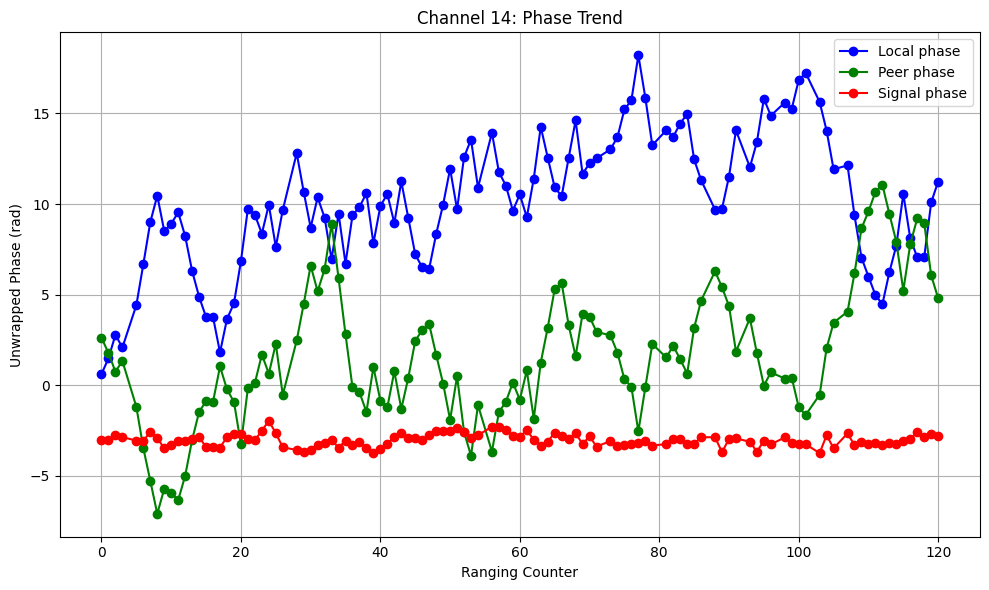

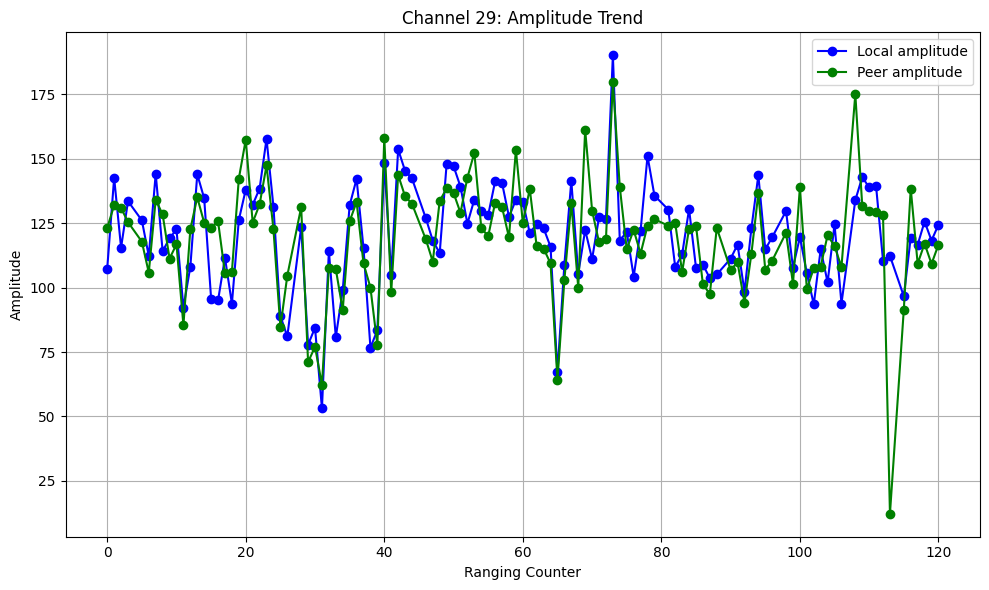

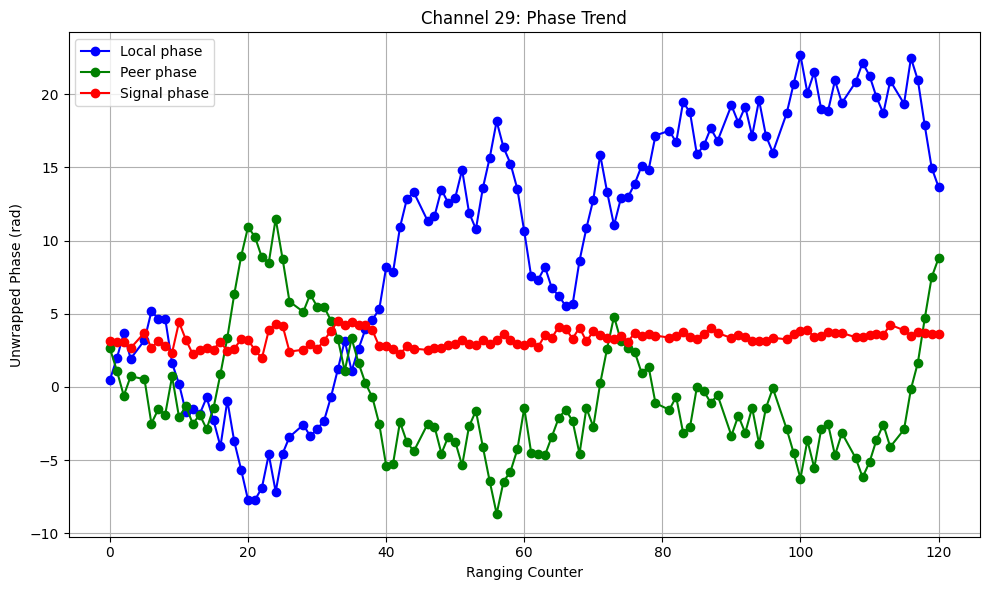

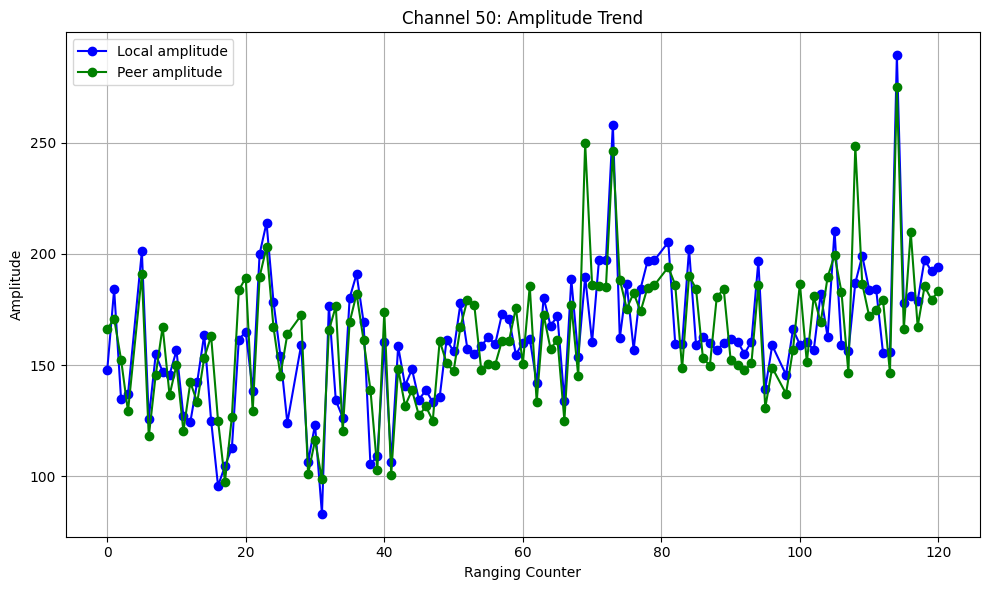

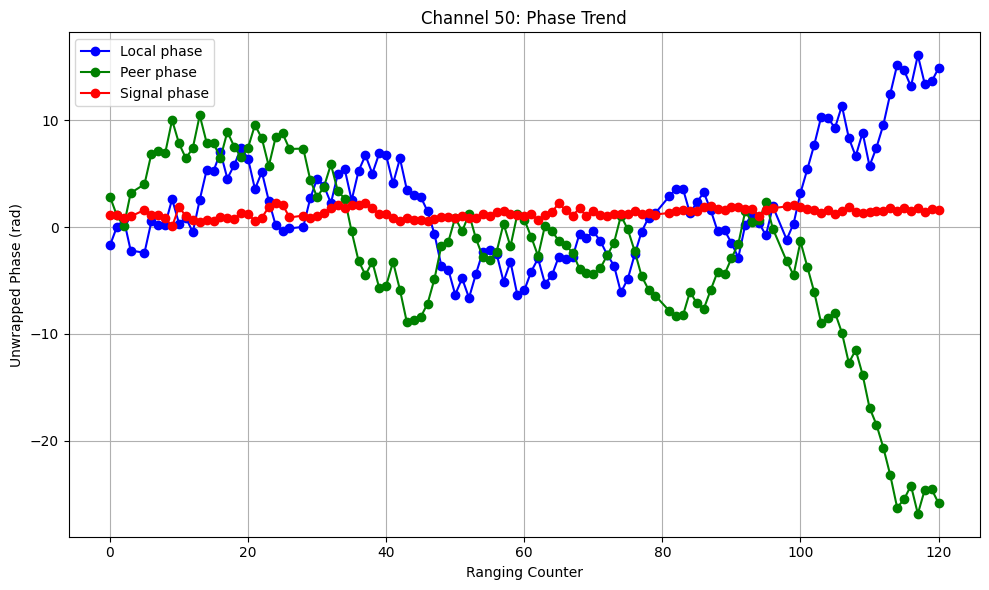

In [91]:
import numpy as np
import matplotlib.pyplot as plt

def plot_iq_trend(data_per_counter, channels_to_plot):
    """
    随着counter变化，绘制每个指定channel的local/peer/signal的幅值和相位趋势
    """
    counters = sorted(data_per_counter.keys())
    for ch in channels_to_plot:
        # 针对每个信道，收集各counter下的local/peer/signal幅值和相位
        local_amp, peer_amp, signal_amp = [], [], []
        local_phs, peer_phs, signal_phs = [], [], []
        valid_counters = []
        for counter in counters:
            ch_list = data_per_counter[counter]
            entry = next((e for e in ch_list if e['channel'] == ch), None)
            if entry is not None:
                local_amp.append(entry['local']['amplitude'])
                peer_amp.append(entry['peer']['amplitude'])
                signal_amp.append(entry['signal']['amplitude'])
                local_phs.append(entry['local']['phase'])
                peer_phs.append(entry['peer']['phase'])
                signal_phs.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if not valid_counters:
            print(f"Channel {ch} not found in any counter.")
            continue
        
        # 相位展开
        local_phs = np.unwrap(local_phs)
        peer_phs = np.unwrap(peer_phs)
        signal_phs = np.unwrap(signal_phs)
        
        # 画幅值
        plt.figure(figsize=(10,6))
        plt.plot(valid_counters, local_amp, 'b-o', label='Local amplitude')
        plt.plot(valid_counters, peer_amp, 'g-o', label='Peer amplitude')
        # plt.plot(valid_counters, signal_amp, 'r-o', label='Signal amplitude')
        plt.xlabel('Ranging Counter')
        plt.ylabel('Amplitude')
        plt.title(f'Channel {ch}: Amplitude Trend')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        # 画相位
        plt.figure(figsize=(10,6))
        plt.plot(valid_counters, local_phs, 'b-o', label='Local phase')
        plt.plot(valid_counters, peer_phs, 'g-o', label='Peer phase')
        plt.plot(valid_counters, signal_phs, 'r-o', label='Signal phase')
        # plt.ylim(-10, 10)
        plt.xlabel('Ranging Counter')
        plt.ylabel('Unwrapped Phase (rad)')
        plt.title(f'Channel {ch}: Phase Trend')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

# 用法举例
if __name__ == '__main__':
    # 假设 data_per_counter 已经由上面的 parse_and_process_iq 生成
    channels_to_plot = [2, 14, 29, 50]  # 你希望观察的信道号
    plot_iq_trend(data_per_counter, channels_to_plot)

local,peer,signal 的幅值相位变化。注意signal 的幅值就是peer，乘积的幅值没有实际意义。

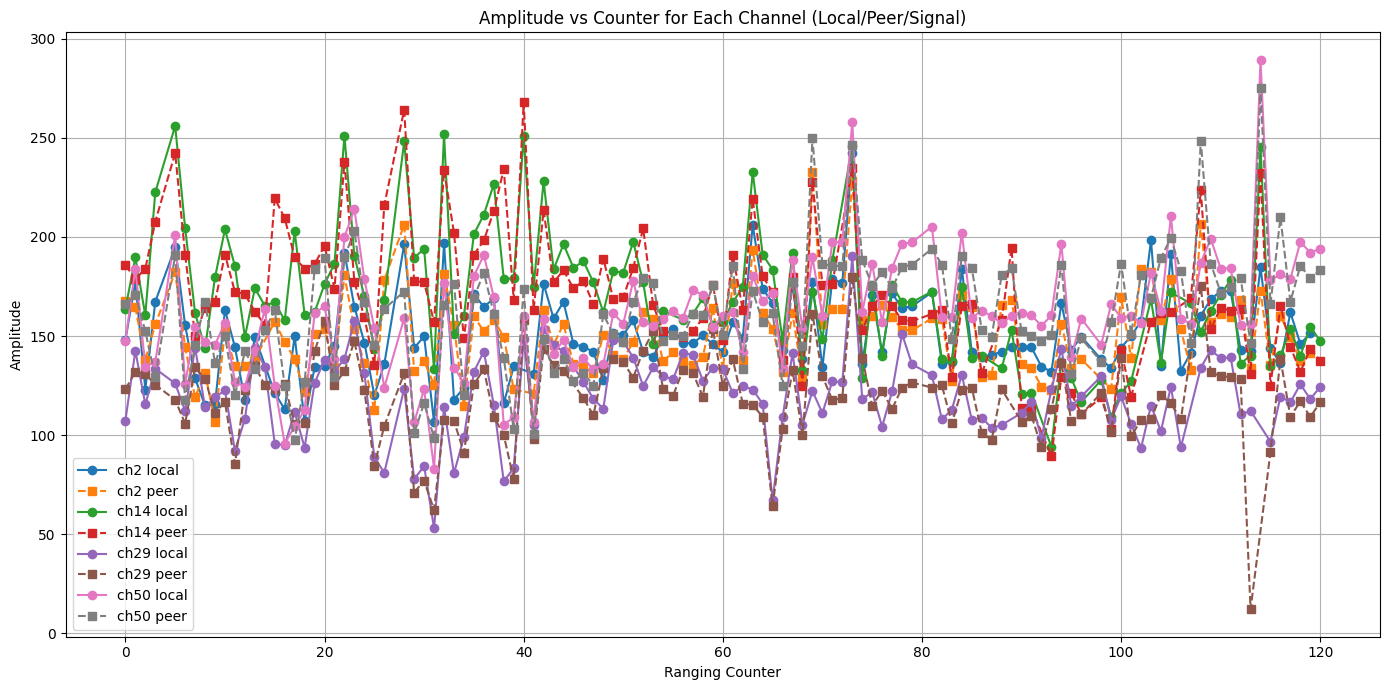

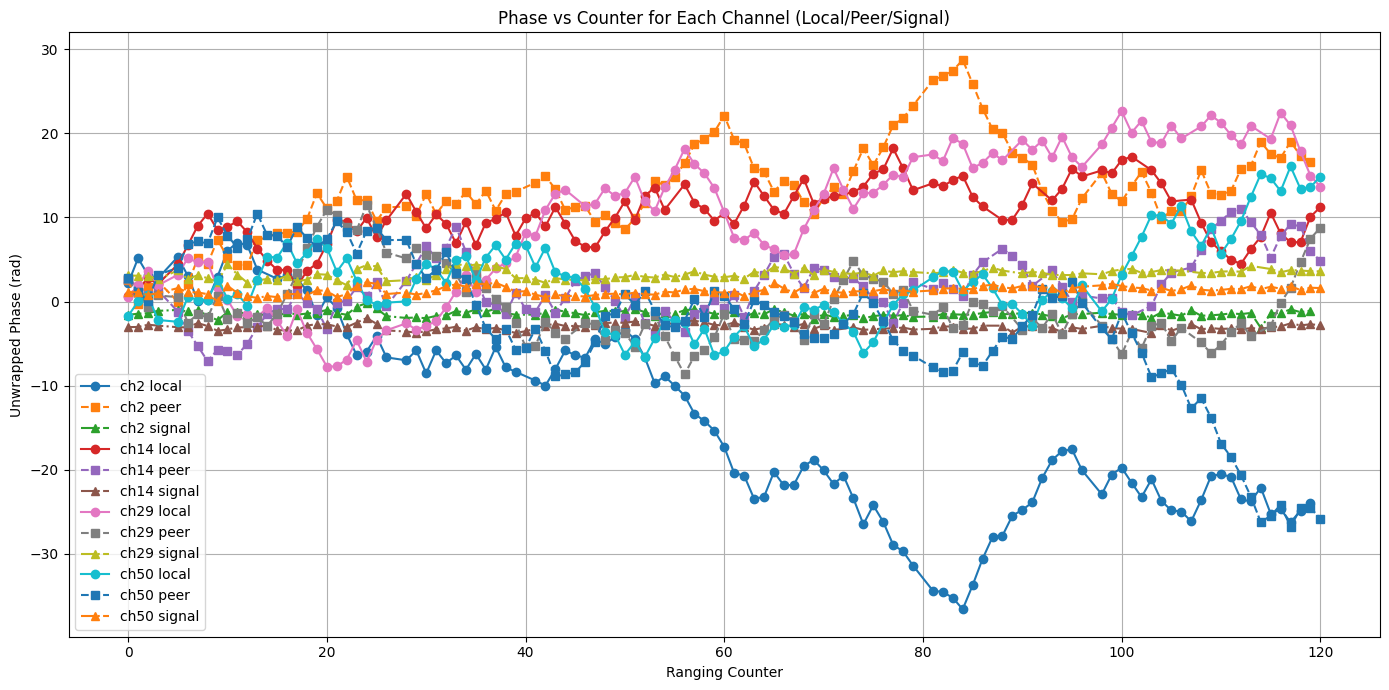

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def plot_amplitude_vs_counter(data_per_counter, channels_to_plot):
    """
    幅值随counter变化。每个信道画三条曲线：local/peer/signal的amplitude。
    """
    counters = sorted(data_per_counter.keys())
    plt.figure(figsize=(14, 7))
    for ch in channels_to_plot:
        # 收集数据
        local_amp, peer_amp, signal_amp, valid_counters = [], [], [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                local_amp.append(entry['local']['amplitude'])
                peer_amp.append(entry['peer']['amplitude'])
                signal_amp.append(entry['signal']['amplitude'])
                valid_counters.append(counter)
        if valid_counters:
            plt.plot(valid_counters, local_amp, '-o', label=f'ch{ch} local')
            plt.plot(valid_counters, peer_amp, '--s', label=f'ch{ch} peer')
            # plt.plot(valid_counters, signal_amp, '-.^', label=f'ch{ch} signal')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Counter for Each Channel (Local/Peer/Signal)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_phase_vs_counter(data_per_counter, channels_to_plot):
    """
    相位随counter变化。每个信道画三条曲线：local/peer/signal的phase。
    """
    counters = sorted(data_per_counter.keys())
    plt.figure(figsize=(14, 7))
    for ch in channels_to_plot:
        local_phs, peer_phs, signal_phs, valid_counters = [], [], [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                local_phs.append(entry['local']['phase'])
                peer_phs.append(entry['peer']['phase'])
                signal_phs.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if valid_counters:
            # 相位展开
            local_phs = np.unwrap(local_phs)
            peer_phs = np.unwrap(peer_phs)
            signal_phs = np.unwrap(signal_phs)
            plt.plot(valid_counters, local_phs, '-o', label=f'ch{ch} local')
            plt.plot(valid_counters, peer_phs, '--s', label=f'ch{ch} peer')
            plt.plot(valid_counters, signal_phs, '-.^', label=f'ch{ch} signal')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Unwrapped Phase (rad)')
    plt.title('Phase vs Counter for Each Channel (Local/Peer/Signal)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# 用法举例
if __name__ == '__main__':
    # 假设 data_per_counter 已由 parse_and_process_iq 生成
    channels_to_plot = [2, 14, 29, 50]  # 可自由指定
    plot_amplitude_vs_counter(data_per_counter, channels_to_plot)
    plot_phase_vs_counter(data_per_counter, channels_to_plot)

local,peer,signal 的幅值相位变化。注意signal 的幅值就是peer，乘积的幅值没有实际意义。

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3715841649.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


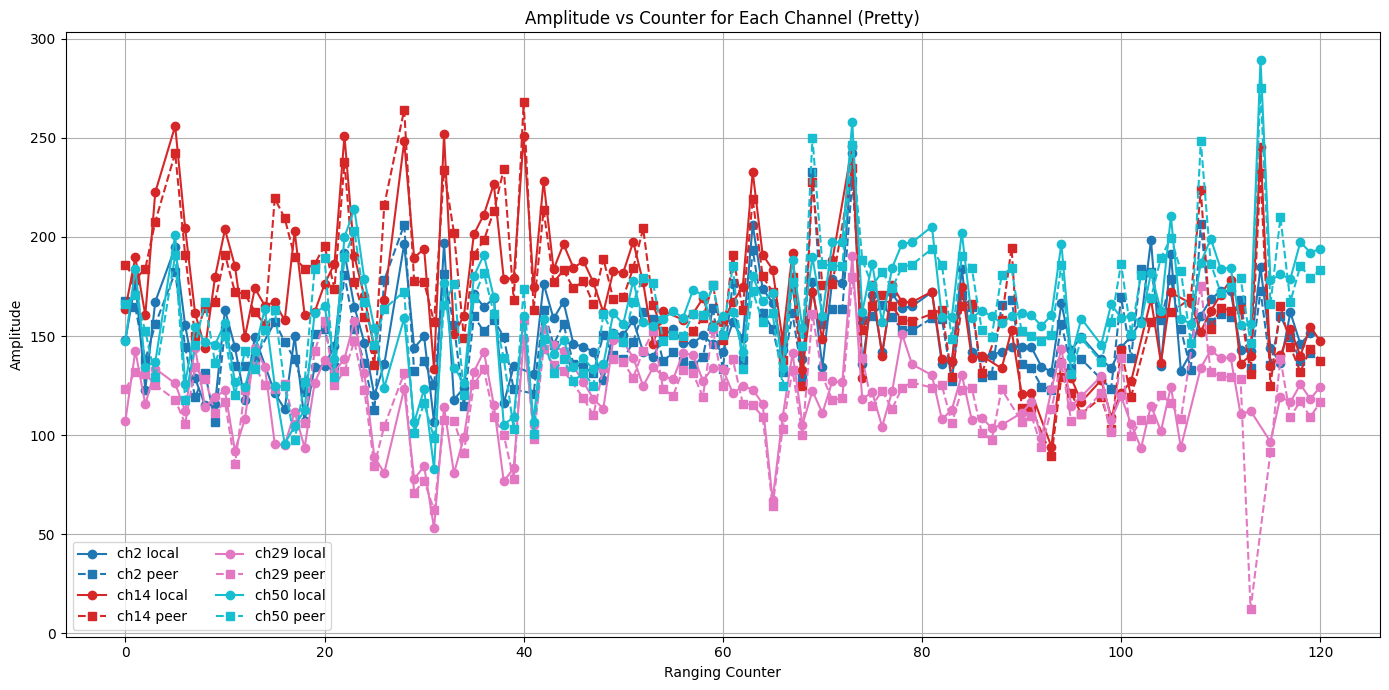

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3715841649.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


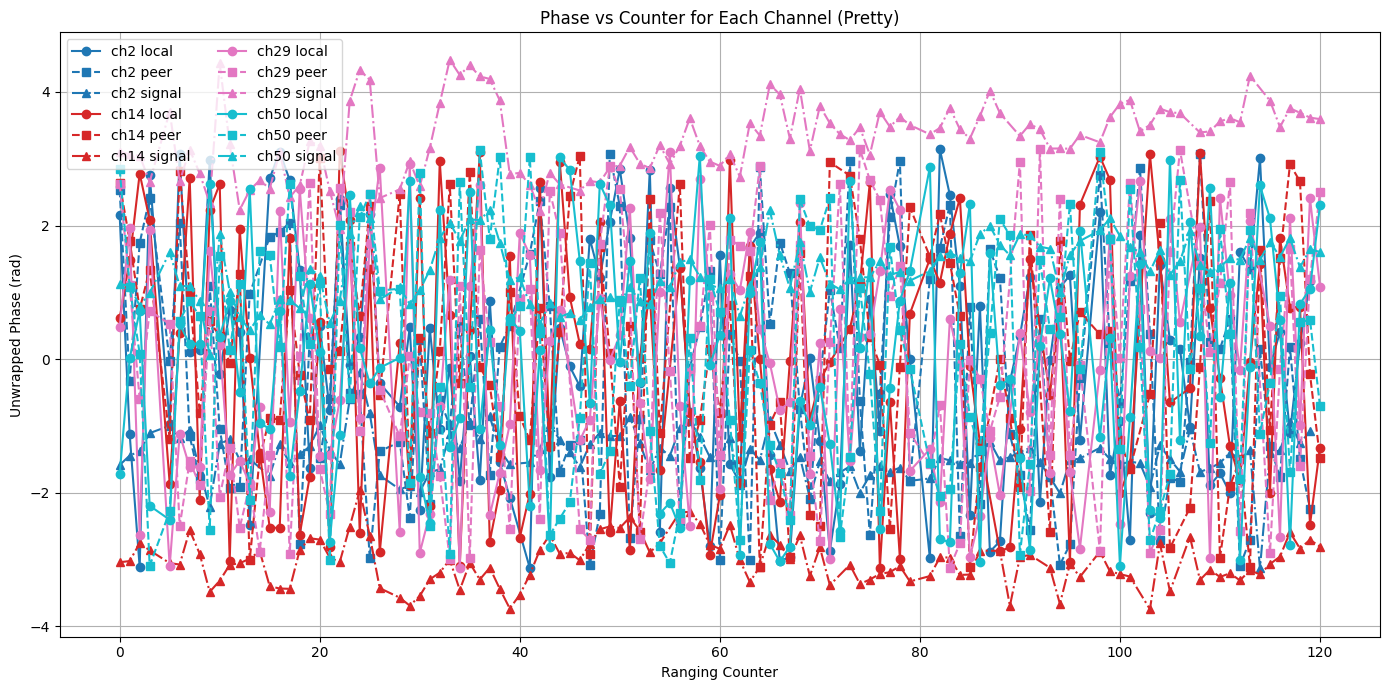

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_amplitude_vs_counter_pretty(data_per_counter, channels_to_plot):
    """
    更美观的幅值随counter变化图，同一信道同色，local/peer/signal不同线型
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    line_styles = {'local': '-o', 'peer': '--s', 'signal': '-.^'}
    labels = {'local': 'local', 'peer': 'peer', 'signal': 'signal'}

    plt.figure(figsize=(14, 7))
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        for kind in ['local', 'peer']:
            y, valid_counters = [], []
            for counter in counters:
                entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
                if entry:
                    y.append(entry[kind]['amplitude'])
                    valid_counters.append(counter)
            if valid_counters:
                plt.plot(valid_counters, y, line_styles[kind], color=color,
                         label=f'ch{ch} {labels[kind]}')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Counter for Each Channel (Pretty)')
    plt.legend(loc='best', ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_phase_vs_counter_pretty(data_per_counter, channels_to_plot):
    """
    更美观的相位随counter变化图，同一信道同色，local/peer/signal不同线型
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    line_styles = {'local': '-o', 'peer': '--s', 'signal': '-.^'}
    labels = {'local': 'local', 'peer': 'peer', 'signal': 'signal'}

    plt.figure(figsize=(14, 7))
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        for kind in ['local', 'peer', 'signal']:
            y, valid_counters = [], []
            for counter in counters:
                entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
                if entry:
                    y.append(entry[kind]['phase'])
                    valid_counters.append(counter)
            if valid_counters:
                if kind == 'signal':
                    # 对信号相位进行展开处理
                    y = np.unwrap(y)
                plt.plot(valid_counters, y, line_styles[kind], color=color,
                         label=f'ch{ch} {labels[kind]}')
    plt.xlabel('Ranging Counter')
    plt.ylabel('Unwrapped Phase (rad)')
    plt.title('Phase vs Counter for Each Channel (Pretty)')
    plt.legend(loc='best', ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()

channels_to_plot = [2, 14, 29, 50]  # 可自由调节
plot_amplitude_vs_counter_pretty(data_per_counter, channels_to_plot)
plot_phase_vs_counter_pretty(data_per_counter, channels_to_plot)

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3522028030.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


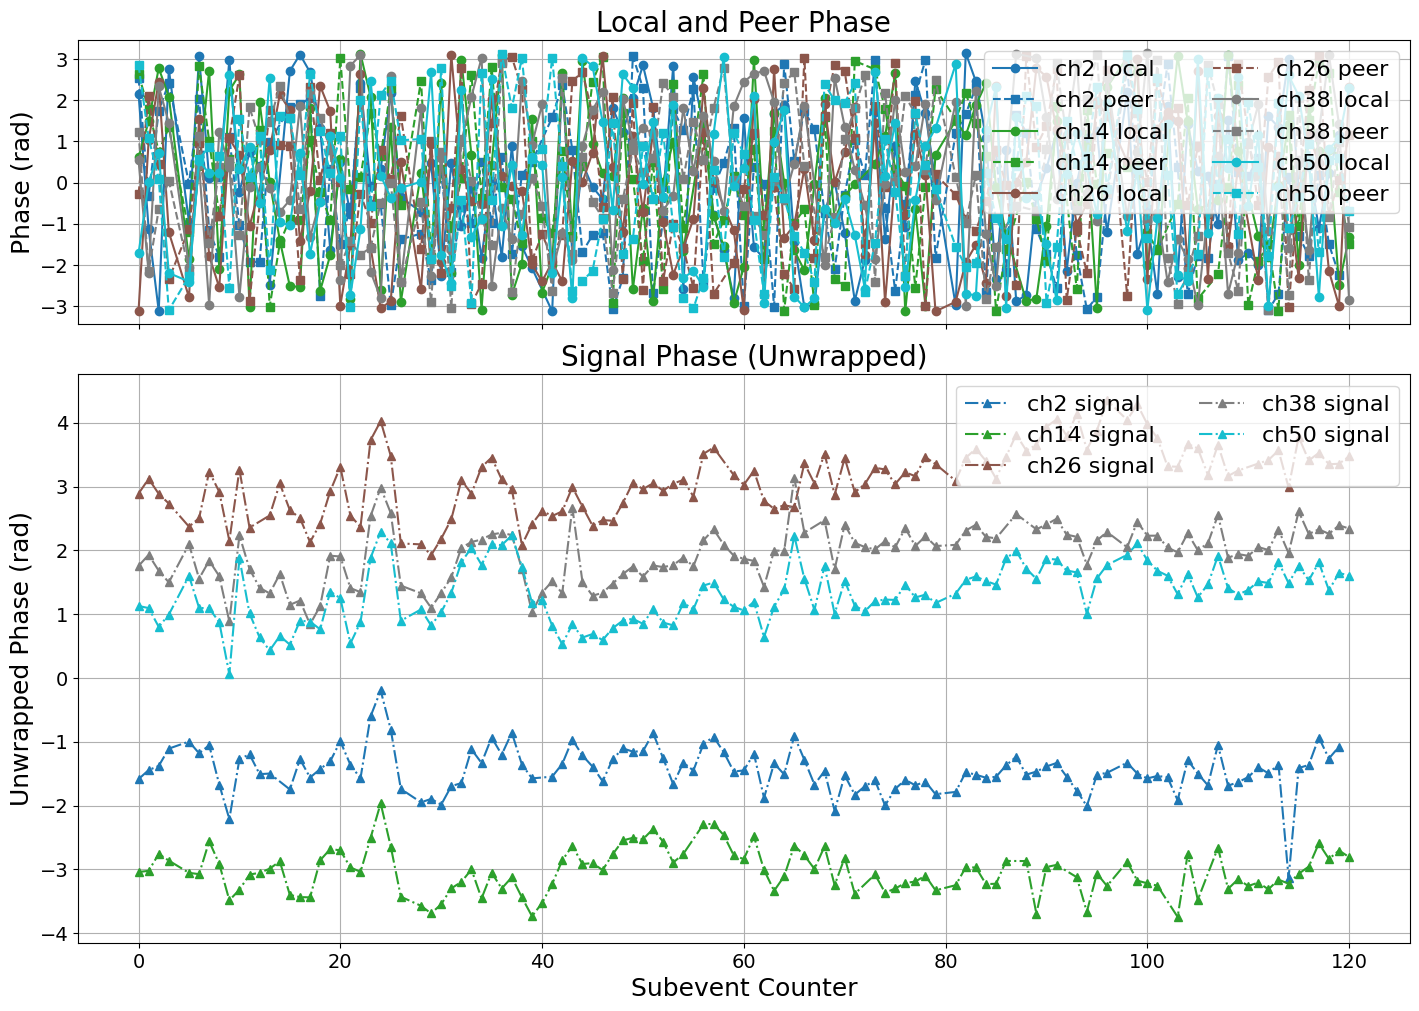

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_phase_vs_counter_pretty_subplots(data_per_counter, channels_to_plot):
    """
    local/peer 不展开，画在上面子图；
    signal 展开，画在下面子图；
    同一信道同色，local/peer/signal不同线型
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    markers = {'local': 'o', 'peer': 's', 'signal': '^'}
    line_styles = {'local': '-o', 'peer': '--s', 'signal': '-.^'}
    labels = {'local': 'local', 'peer': 'peer', 'signal': 'signal'}

    # cm=1/2.54  # cm to inch
    pt = 1/72.27  # point to inch
    linewidth = 246*pt
    textwidth = 506*pt  # 0.5 cm in points
    axis_label_size = 18   # 坐标轴标签字体
    title_size = 20        # 图标题字体
    legend_size = 16       # 图例字体
    tick_size = 14         # 坐标轴刻度字体
    scale_size = 3 #缩放倍数
    spine_width = 2 # 边框宽度

    fig, axs = plt.subplots(2, 1, figsize=(scale_size*1.4*linewidth, scale_size* 1.0 *linewidth), sharex=True, gridspec_kw={'height_ratios': [1, 2]})

    # 上面：local 和 peer
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        for kind in ['local', 'peer']:
            y, valid_counters = [], []
            for counter in counters:
                entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
                if entry:
                    y.append(entry[kind]['phase'])
                    valid_counters.append(counter)
            if valid_counters:
                axs[0].plot(valid_counters, y, line_styles[kind], color=color, label=f'ch{ch} {labels[kind]}')
                # axs[0].scatter(valid_counters, y, marker=markers[kind], color=color, s=10, label=f'ch{ch} {labels[kind]}', alpha=0.7)
    axs[0].set_ylabel('Phase (rad)',fontsize=axis_label_size)
    axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
    axs[0].set_title('Local and Peer Phase', fontsize=title_size)
    # axs[0].legend(loc='best', ncol=2, fontsize=legend_size)
    axs[0].legend(loc='upper right', ncol=2, fontsize=legend_size)
    axs[0].grid()
    
    # 下面：signal
    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        y, valid_counters = [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                y.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if valid_counters:
            y = np.unwrap(y)
            axs[1].plot(valid_counters, y, line_styles['signal'], color=color, label=f'ch{ch} signal')
    axs[1].set_xlabel('Subevent Counter',fontsize=axis_label_size)
    axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
    axs[1].set_ylabel('Unwrapped Phase (rad)', fontsize=axis_label_size)
    axs[1].set_title('Signal Phase (Unwrapped)', fontsize=title_size)
    # axs[1].legend(loc='best', ncol=2, fontsize=legend_size)
    axs[1].legend(loc='upper right', ncol=2, fontsize=legend_size)
    axs[1].grid()

    plt.tight_layout()
    plt.savefig("./poster.fig/channel_variation_human_effect.svg", dpi=300)  # 保存图像
    plt.show()

# 用法
channels_to_plot = [2,  14,  26, 38, 50]
# channels_to_plot =[ 2,  5,  8,  11, 14, 17, 20, 23, 26, 29, 32,35, 38, 41, 44, 47, 50]
plot_phase_vs_counter_pretty_subplots(data_per_counter, channels_to_plot)

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1139871523.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', n_ch)


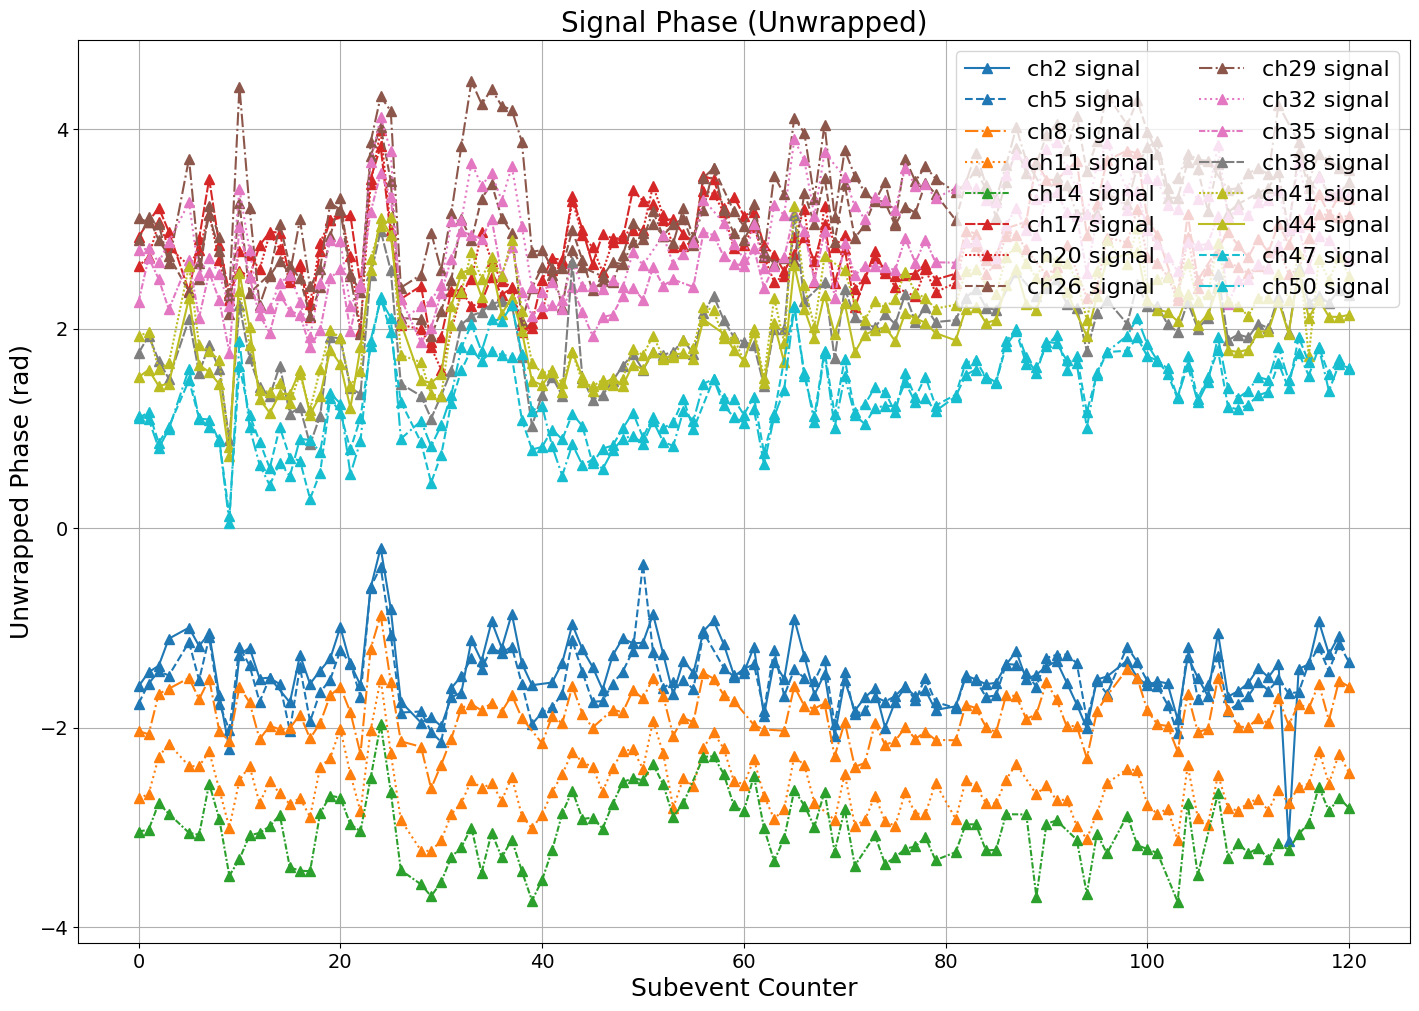

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_phase_vs_counter_signal_only(data_per_counter, channels_to_plot):
    """
    signal 展开，画在单图中；
    同一信道同色，同一信道三角形标志
    """
    counters = sorted(data_per_counter.keys())
    n_ch = len(channels_to_plot)
    color_map = cm.get_cmap('tab10', n_ch)
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]
    marker = '^'  # 三角形标记
    axis_label_size = 18
    title_size = 20
    legend_size = 16
    tick_size = 14
    scale_size = 3
    pt = 1/72.27
    linewidth = 246*pt

    fig, ax = plt.subplots(figsize=(scale_size*1.4*linewidth, scale_size*1.0*linewidth))

    for idx, ch in enumerate(channels_to_plot):
        color = color_map(idx)
        y, valid_counters = [], []
        for counter in counters:
            entry = next((e for e in data_per_counter[counter] if e['channel'] == ch), None)
            if entry:
                y.append(entry['signal']['phase'])
                valid_counters.append(counter)
        if valid_counters:
            y = np.unwrap(y)
            style = line_styles[idx % len(line_styles)]
            # 画线并加三角形标志
            ax.plot(valid_counters, y, linestyle=style, color=color, marker=marker, markersize=7, label=f'ch{ch} signal')

    ax.set_xlabel('Subevent Counter', fontsize=axis_label_size)
    # ax.set_ylim(-7,2)
    ax.set_ylabel('Unwrapped Phase (rad)', fontsize=axis_label_size)
    ax.set_title('Signal Phase (Unwrapped)', fontsize=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
    ax.legend(loc='upper right', ncol=2, fontsize=legend_size)
    ax.grid()

    plt.tight_layout()
    plt.savefig("./poster.fig/channel_variation_single_human_effect.svg", dpi=300)
    plt.show()

# 用法
# channels_to_plot = [2, 14, 26, 38, 50]
channels_to_plot = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50]
plot_phase_vs_counter_signal_only(data_per_counter, channels_to_plot)



单次采样的相位变化，可见mode-0确实需要每一次都执行。否则，local应该是静止的

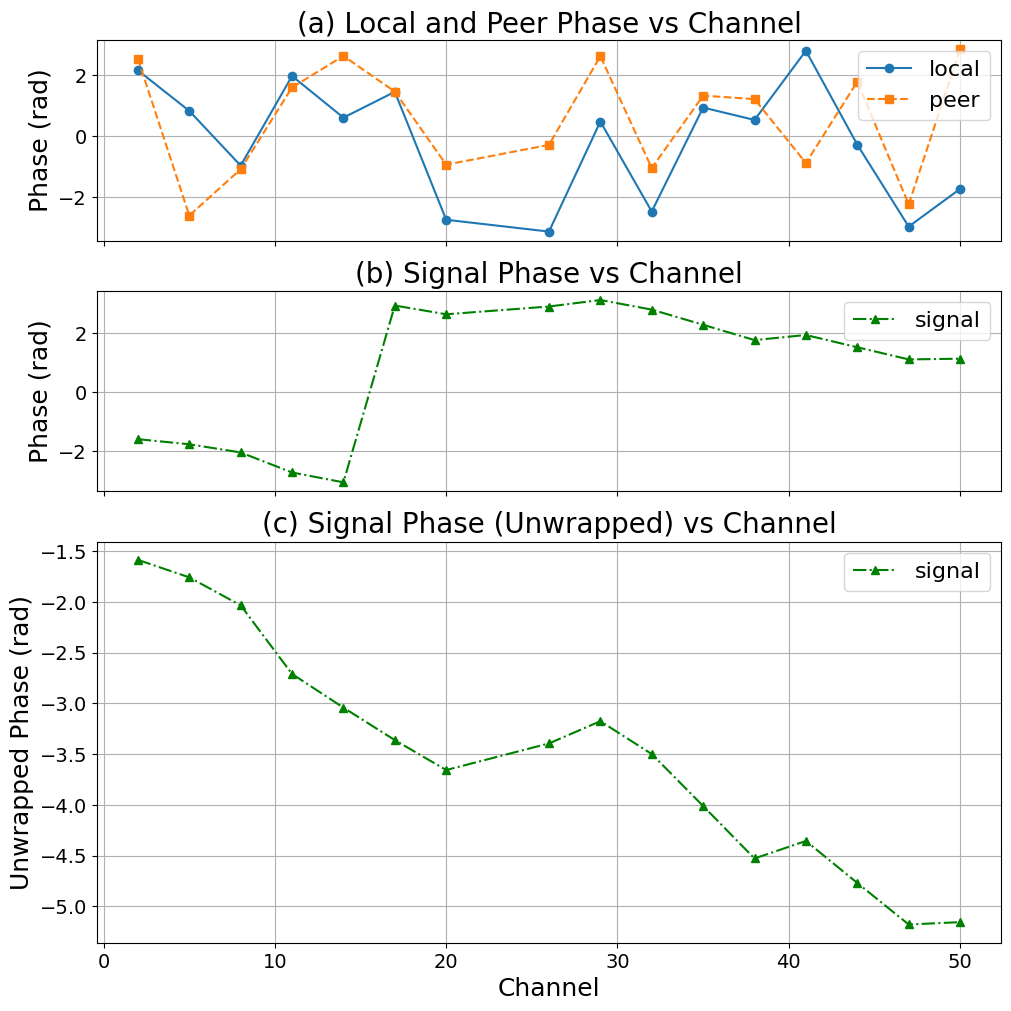

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def plot_phase_vs_channel_at_counter(data_per_counter, counter):
    """
    展示某一counter下，所有channel的local/peer/signal相位随channel变化
    """
    if counter not in data_per_counter:
        print(f"Counter {counter} not found.")
        return
    ch_entries = sorted(data_per_counter[counter], key=lambda e: e['channel'])
    channels = [e['channel'] for e in ch_entries]
    # local_phs = np.unwrap([e['local']['phase'] for e in ch_entries])
    local_phs = [e['local']['phase'] for e in ch_entries]
    # peer_phs  = np.unwrap([e['peer']['phase']  for e in ch_entries])
    peer_phs  = [e['peer']['phase']  for e in ch_entries]
    signal_phs= [e['signal']['phase'] for e in ch_entries]
    signal_phs_uw= np.unwrap([e['signal']['phase'] for e in ch_entries])

    cm=1/2.54  # cm to inch
    pt = 1/72.27  # point to inch
    linewidth = 246*pt
    textwidth = 506*pt  # 0.5 cm in points
    axis_label_size = 18   # 坐标轴标签字体
    title_size = 20        # 图标题字体
    legend_size = 16       # 图例字体
    tick_size = 14         # 坐标轴刻度字体
    scale_size = 3 #缩放倍数
    spine_width = 2 # 边框宽度
    fig, axs = plt.subplots(3, 1, figsize=(scale_size*linewidth, scale_size* 1.0 *linewidth), sharex=True, gridspec_kw={'height_ratios': [1, 1,2]})

        # 上面：local 和 peer
    axs[0].plot(channels, local_phs, '-o', label='local')
    axs[0].plot(channels, peer_phs, '--s', label='peer')
    axs[0].set_ylabel('Phase (rad)',fontsize=axis_label_size)
    axs[0].set_title('(a) Local and Peer Phase vs Channel',fontsize=title_size)
    axs[0].legend(fontsize=legend_size, loc='upper right')
    axs[0].grid()
    axs[0].tick_params(axis='both', labelsize=tick_size)  # 设置刻度字体
    
    # 下面：signal
    axs[1].plot(channels, signal_phs, '-.^', label='signal', color='g')
    # axs[1].set_xlabel('Channel',fontsize=axis_label_size)
    axs[1].set_ylabel('Phase (rad)',fontsize=axis_label_size)
    axs[1].set_title('(b) Signal Phase vs Channel',fontsize=title_size)
    axs[1].legend(fontsize=legend_size)
    axs[1].grid()
    axs[1].tick_params(axis='both', labelsize=tick_size)  # 设置刻度字体

    # 下面：signal unwrapped
    axs[2].plot(channels, signal_phs_uw, '-.^', label='signal', color='g')
    axs[2].set_xlabel('Channel',fontsize=axis_label_size)
    axs[2].set_ylabel('Unwrapped Phase (rad)',fontsize=axis_label_size)
    axs[2].set_title('(c) Signal Phase (Unwrapped) vs Channel',fontsize=title_size)
    axs[2].legend(fontsize=legend_size)
    axs[2].grid()
    axs[2].tick_params(axis='both', labelsize=tick_size)  # 设置刻度字体

    plt.tight_layout()
    plt.savefig(f'./poster.fig/counter_{counter}_phase_vs_channel.svg', dpi=300)
    plt.savefig(f'./poster.fig/counter_{counter}_phase_vs_channel.pdf', dpi=300)
    plt.show()

plot_phase_vs_channel_at_counter(data_per_counter, counter=0)  # counter编号可自定

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:32: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:32: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:32: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:32: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:32: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:32: UserWarning: Glyph 21495 (\N{CJK 

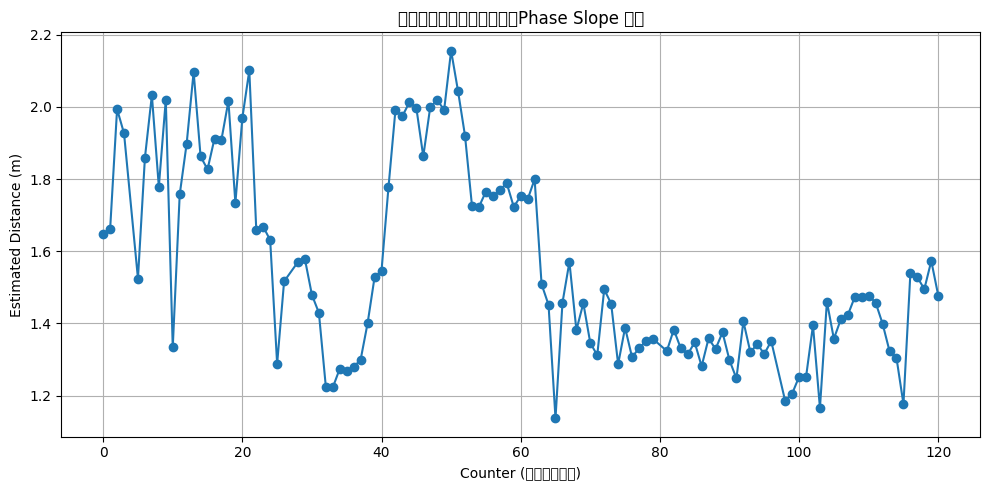

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:52: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:52: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:52: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:52: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:52: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\2684743801.py:52: UserWarning: Glyph 21495 (\N{CJK 

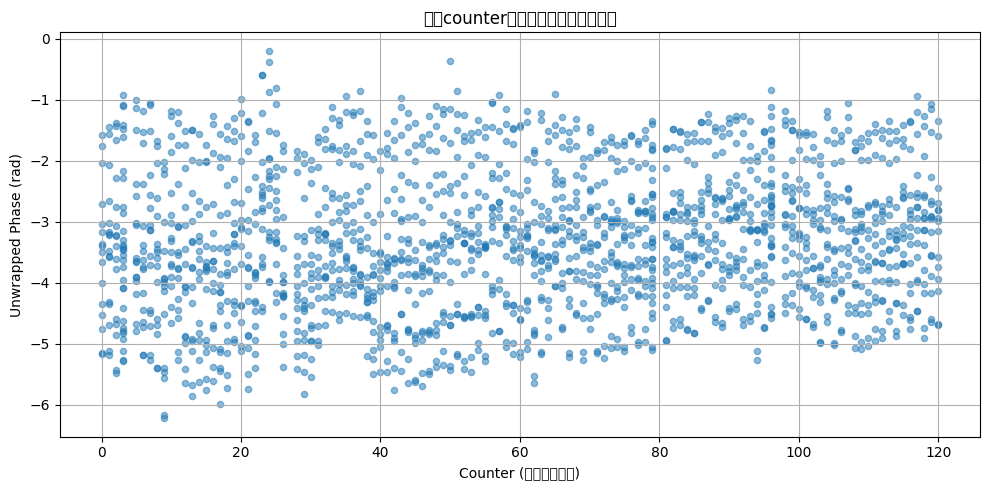

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_distance_phase_slope(signal_phases, channels):
    frequencies = np.array([2402 + ch for ch in channels], dtype=np.float64)
    phases_uw = np.unwrap(signal_phases)
    b, _ = np.polyfit(frequencies, phases_uw, 1)
    SPEED_OF_LIGHT = 299_792_458.0
    distance = -b * (SPEED_OF_LIGHT / (4 * np.pi)) / 1_000_000
    return distance,phases_uw

distances = []
phase_multich = []
counters = sorted(data_per_counter.keys())
for cnt in counters:
    ch_entries = sorted(data_per_counter[cnt], key=lambda e: e['channel'])
    channels = [e['channel'] for e in ch_entries]
    signal_phs = [e['signal']['phase'] for e in ch_entries]
    if len(channels) < 2:
        distances.append(np.nan)
        continue
    d,pu = estimate_distance_phase_slope(np.array(signal_phs), np.array(channels))
    distances.append(d)
    phase_multich.append(pu)

plt.figure(figsize=(10,5))
plt.plot(counters, distances, '-o')
plt.xlabel('Counter (测距事件编号)')
plt.ylabel('Estimated Distance (m)')
plt.title('距离随测距次数变化曲线（Phase Slope 法）')
plt.grid(True)
plt.tight_layout()
plt.savefig('./poster.fig/distance_vs_counter.svg', dpi=300)
plt.savefig('./poster.fig/distance_vs_counter.pdf', dpi=300)
plt.show()


# 展开所有点
X = []
Y = []
for idx, pu in enumerate(phase_multich):
    for val in pu:
        X.append(counters[idx])
        Y.append(val)

plt.figure(figsize=(10,5))
plt.scatter(X, Y, alpha=0.5, s=20)
plt.xlabel('Counter (测距事件编号)')
plt.ylabel('Unwrapped Phase (rad)')
plt.title('所有counter的各信道相位展开点分布')
plt.grid(True)
plt.tight_layout()
plt.savefig('./poster.fig/all_phase_points_vs_counter.svg', dpi=300)
plt.savefig('./poster.fig/all_phase_points_vs_counter.pdf', dpi=300)
plt.show()

# plt.savefig('./poster.fig/distance_vs_counter.svg', dpi=300)
# plt.savefig('./poster.fig/distance_vs_counter.pdf', dpi=300)
plt.show()

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3712038836.py:31: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3712038836.py:31: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3712038836.py:31: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3712038836.py:31: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3712038836.py:31: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\3712038836.py:31: UserWarning: Glyph 21495 (\N{CJK 

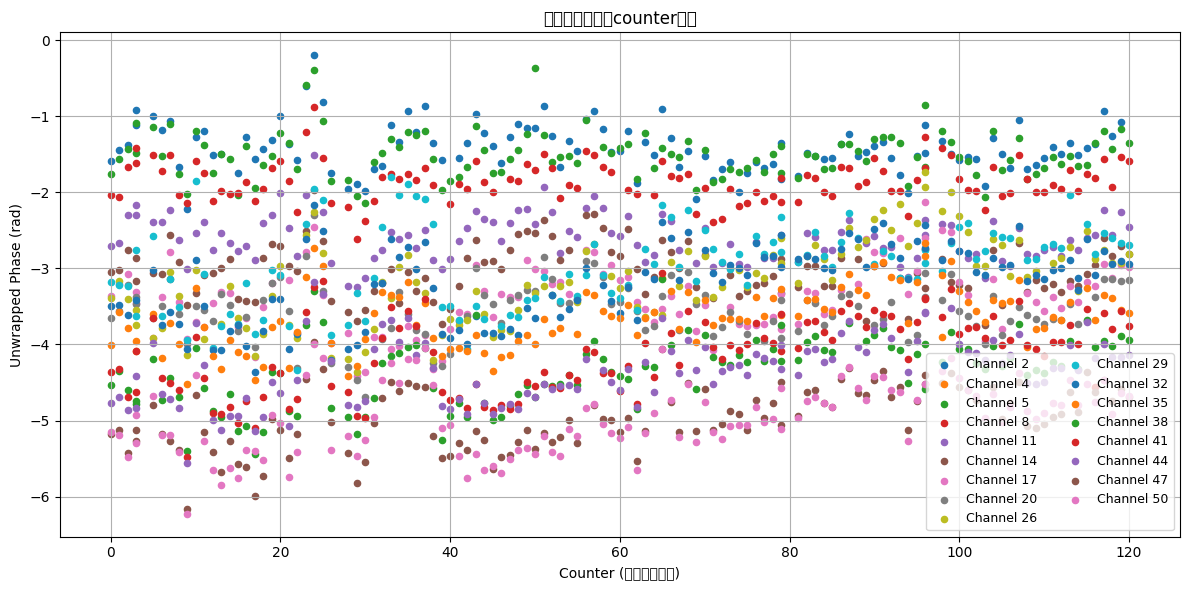

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 统计所有出现过的信道编号
all_channels = set()
for entries in data_per_counter.values():
    all_channels.update(e['channel'] for e in entries)
all_channels = sorted(all_channels)

# 2. 按信道分组准备数据
channel2counters = {ch: [] for ch in all_channels}
channel2phases   = {ch: [] for ch in all_channels}

for idx, pu in enumerate(phase_multich):
    counter = counters[idx]
    ch_entries = sorted(data_per_counter[counter], key=lambda e: e['channel'])
    for i, ch in enumerate([e['channel'] for e in ch_entries]):
        channel2counters[ch].append(counter)
        channel2phases[ch].append(pu[i])

# 3. 绘图：每个信道一种颜色
plt.figure(figsize=(12,6))
for ch in all_channels:
    plt.scatter(channel2counters[ch], channel2phases[ch], label=f'Channel {ch}', s=20)

plt.xlabel('Counter (测距事件编号)')
plt.ylabel('Unwrapped Phase (rad)')
plt.title('各信道的相位随counter变化')
plt.legend(fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('./poster.fig/all_channel_phase_vs_counter.svg', dpi=300)
plt.savefig('./poster.fig/all_channel_phase_vs_counter.pdf', dpi=300)
plt.show()

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1495771337.py:31: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1495771337.py:31: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1495771337.py:31: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1495771337.py:31: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1495771337.py:31: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\1495771337.py:31: UserWarning: Glyph 21495 (\N{CJK 

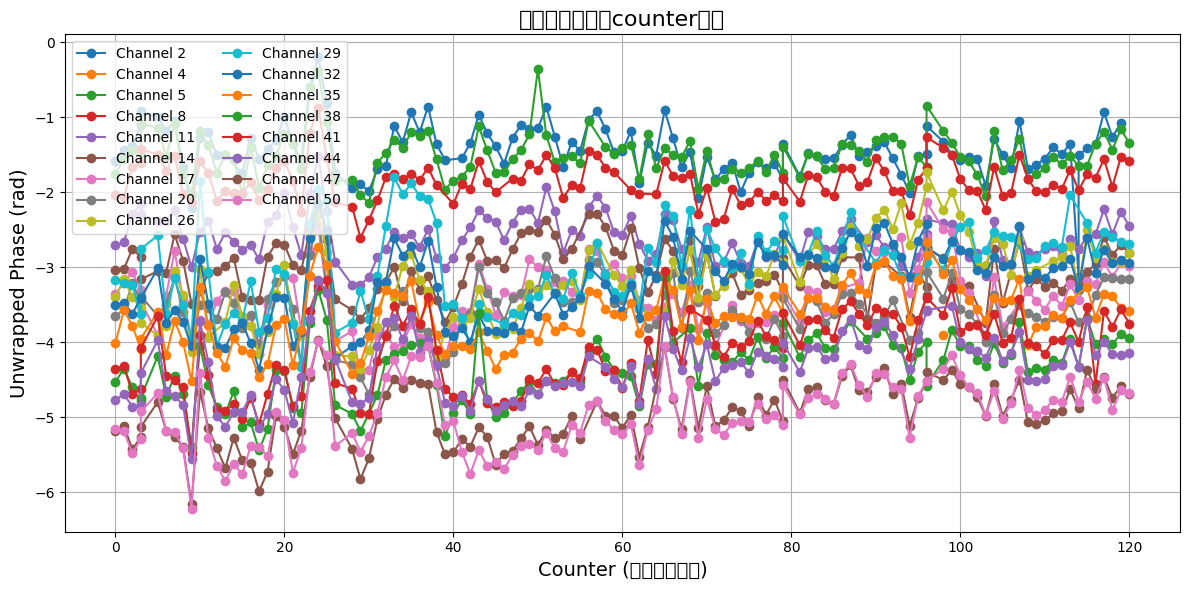

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 统计所有出现过的信道编号
all_channels = set()
for entries in data_per_counter.values():
    all_channels.update(e['channel'] for e in entries)
all_channels = sorted(all_channels)

# 2. 按信道分组，每个信道一条线
channel2counters = {ch: [] for ch in all_channels}
channel2phases   = {ch: [] for ch in all_channels}

for idx, pu in enumerate(phase_multich):
    counter = counters[idx]
    ch_entries = sorted(data_per_counter[counter], key=lambda e: e['channel'])
    for i, ch in enumerate([e['channel'] for e in ch_entries]):
        channel2counters[ch].append(counter)
        channel2phases[ch].append(pu[i])

# 3. 绘图，每个信道一条折线+marker
plt.figure(figsize=(12,6))
for ch in all_channels:
    plt.plot(channel2counters[ch], channel2phases[ch], marker='o', label=f'Channel {ch}')

plt.xlabel('Counter (测距事件编号)', fontsize=14)
plt.ylabel('Unwrapped Phase (rad)', fontsize=14)
plt.title('各信道的相位随counter变化', fontsize=16)
plt.legend(fontsize=10, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('./poster.fig/all_channel_phase_vs_counter_lines.svg', dpi=300)
plt.savefig('./poster.fig/all_channel_phase_vs_counter_lines.pdf', dpi=300)
plt.show()

C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\209292473.py:34: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\209292473.py:34: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\209292473.py:34: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\209292473.py:34: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\209292473.py:34: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_6272\209292473.py:34: UserWarning: Glyph 21495 (\N{CJK UNIFIE

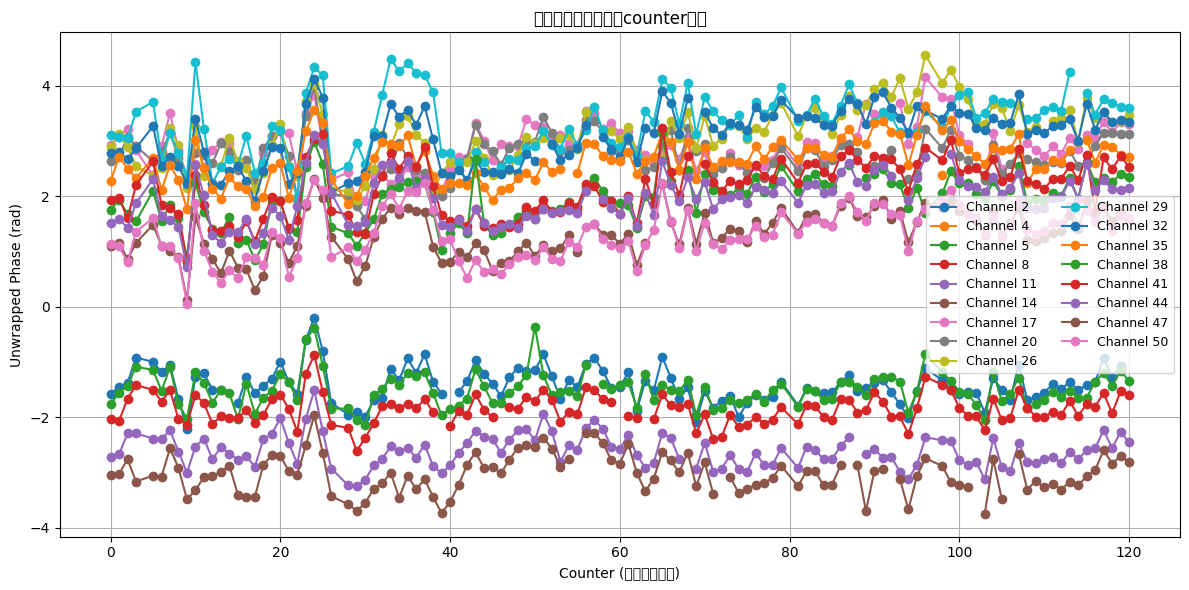

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 汇总所有信道编号
all_channels = set()
for entries in data_per_counter.values():
    all_channels.update(e['channel'] for e in entries)
all_channels = sorted(all_channels)

# 2. 构建信道-相位矩阵
counters = sorted(data_per_counter.keys())
phase_matrix = np.full((len(all_channels), len(counters)), np.nan)

for idx_c, cnt in enumerate(counters):
    ch_entries = {e['channel']: e['signal']['phase'] for e in data_per_counter[cnt]}
    for idx_ch, ch in enumerate(all_channels):
        if ch in ch_entries:
            phase_matrix[idx_ch, idx_c] = ch_entries[ch]

for idx_ch in range(len(all_channels)):
    valid_idx = ~np.isnan(phase_matrix[idx_ch])
    phase_matrix[idx_ch, valid_idx] = np.unwrap(phase_matrix[idx_ch, valid_idx])

# 3. 绘图
plt.figure(figsize=(12,6))
for idx_ch, ch in enumerate(all_channels):
    plt.plot(counters, phase_matrix[idx_ch], marker='o', label=f'Channel {ch}')

plt.xlabel('Counter (测距事件编号)')
plt.ylabel('Unwrapped Phase (rad)')
plt.title('各信道展开后相位随counter变化')
plt.legend(fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('./poster.fig/unwrapped_phase_vs_counter.svg', dpi=300)
plt.savefig('./poster.fig/unwrapped_phase_vs_counter.pdf', dpi=300)
plt.show()